In [221]:
import os
import sys

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data

sys.path.append("..")

from src.gnn import MixHopNet
from src.load_data import load_data
from src.sheaf import CSNN
from src.utils import accuracy, f1_macro

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [222]:
if not os.path.exists("../images"):
    os.makedirs("../images")

## Load dataset


In [223]:
DATASET_NAME = "wisconsin"  # ['texas', 'cornell', 'wisconsin']
SPLIT = [0.7, 0.2, 0.1]  # Train, Val, Test split ratios

In [224]:
torch.manual_seed(42)
data: Data
data, train_mask, val_mask, test_mask, num_classes, class_weights = load_data(
    DATASET_NAME, SPLIT
)

Wisconsin | num_nodes=251 | num_classes=5
Train=174, val=49, test=28
class_counts: [7.0, 49.0, 82.0, 22.0, 14.0]
class_weights: [2.4433090686798096, 0.34904420375823975, 0.20857517421245575, 0.7774165272712708, 1.2216546535491943]


## Sheaf-NN


In [225]:
torch.manual_seed(42)
# Modelo CSNN
model = CSNN(
    in_dim=data.x.size(-1),
    hidden_dim=64,
    out_dim=num_classes,
    num_nodes=data.num_nodes,
    edge_index=data.edge_index,
    num_layers=2,
    dropout=0.6,
).to(device)

### Training


In [226]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss()
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=100, min_lr=1e-5
)

In [227]:
# Históricos para plotting
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []

# Entrenamiento con early stopping
best_val_acc = 0.0
best_state = None
max_epochs = 500

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x)

        # Accuracies
        train_acc = accuracy(out[train_mask], data.y[train_mask])
        val_acc = accuracy(out[val_mask], data.y[val_mask])
        test_acc = accuracy(out[test_mask], data.y[test_mask])

        # F1 macro
        train_f1 = f1_macro(
            out[train_mask], data.y[train_mask], num_classes=num_classes
        )
        val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
        test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

    # Guardar históricos
    train_acc_hist.append(float(train_acc))
    val_acc_hist.append(float(val_acc))
    test_acc_hist.append(float(test_acc))

    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)

    # Early stopping basado en validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 50 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:04d} | "
            f"loss {loss.item():.4f} | "
            f"train acc {train_acc:.4f} | "
            f"val acc {val_acc:.4f} | "
            f"test acc {test_acc:.4f} | "
            f"train f1 {train_f1:.4f} | "
            f"val f1 {val_f1:.4f} | "
            f"test f1 {test_f1:.4f}"
        )

    lr_scheduler.step(val_acc)

# Cargar mejor modelo
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

model.eval()
with torch.no_grad():
    out = model(data.x)
    final_train_acc = accuracy(out[train_mask], data.y[train_mask])
    final_val_acc = accuracy(out[val_mask], data.y[val_mask])
    final_test_acc = accuracy(out[test_mask], data.y[test_mask])

    final_train_f1 = f1_macro(
        out[train_mask], data.y[train_mask], num_classes=num_classes
    )
    final_val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
    final_test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

print(
    f"Final | "
    f"train acc {final_train_acc:.4f} | val acc {final_val_acc:.4f} | test acc {final_test_acc:.4f} | "
    f"train f1 {final_train_f1:.4f} | val f1 {final_val_f1:.4f} | test f1 {final_test_f1:.4f}"
)


Epoch 0001 | loss 1.6205 | train acc 0.4713 | val acc 0.4694 | test acc 0.4643 | train f1 0.1281 | val f1 0.1278 | test f1 0.1268
Epoch 0050 | loss 0.5861 | train acc 0.7529 | val acc 0.7347 | test acc 0.6786 | train f1 0.3390 | val f1 0.3290 | test f1 0.3056
Epoch 0100 | loss 0.4437 | train acc 0.8161 | val acc 0.6531 | test acc 0.6429 | train f1 0.5742 | val f1 0.3598 | test f1 0.3368
Epoch 0150 | loss 0.3282 | train acc 0.9080 | val acc 0.6735 | test acc 0.6786 | train f1 0.7425 | val f1 0.3791 | test f1 0.3607
Epoch 0200 | loss 0.2677 | train acc 0.9195 | val acc 0.6735 | test acc 0.6429 | train f1 0.7517 | val f1 0.3447 | test f1 0.3368
Epoch 0250 | loss 0.1966 | train acc 0.9195 | val acc 0.6939 | test acc 0.6786 | train f1 0.7517 | val f1 0.4200 | test f1 0.3679
Epoch 0300 | loss 0.2325 | train acc 0.9828 | val acc 0.6735 | test acc 0.6429 | train f1 0.9632 | val f1 0.3788 | test f1 0.3368
Epoch 0350 | loss 0.1410 | train acc 0.9943 | val acc 0.7347 | test acc 0.6786 | train f1 

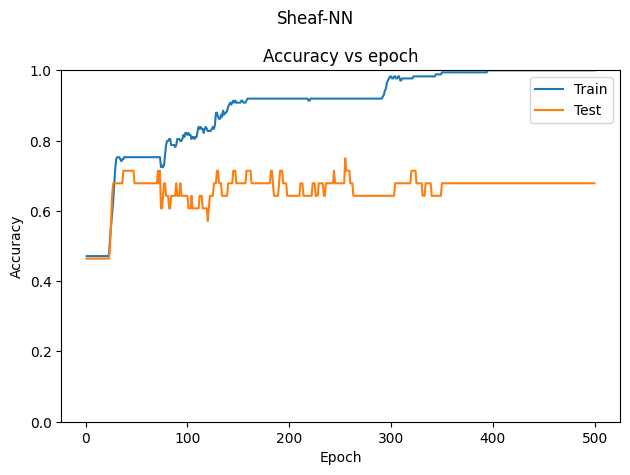

In [228]:
# Gráficas: accuracy y F1 vs epochs para train y test
epochs = range(1, max_epochs + 1)

fig, axes = plt.subplots(1, 1)
fig.suptitle("Sheaf-NN")

# Accuracy
axes.plot(epochs, train_acc_hist, label="Train")
axes.plot(epochs, test_acc_hist, label="Test")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.set_title("Accuracy vs epoch")
axes.set_ylim(0, 1)
axes.legend()

# # F1 macro
# axes[1].plot(epochs, train_f1_hist, label="Train")
# axes[1].plot(epochs, test_f1_hist, label="Test")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("F1 macro")
# axes[1].set_title("F1 vs epoch")
# axes[1].set_ylim(0, 1)
# axes[1].legend()

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(f"../images/comparative_sheaf_{DATASET_NAME}.png", dpi=300)

## GNN


In [215]:
model = MixHopNet(
    in_dim=data.x.size(-1),
    hidden_dim=32,
    out_dim=num_classes,
    dropout=0.8,
    powers=(0, 1, 2),
).to(device)

### Training


In [216]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.01,
    weight_decay=5e-4,
)
criterion = nn.CrossEntropyLoss(weight=class_weights)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=100, min_lr=1e-5
)

In [217]:
# Históricos para plotting
train_acc_hist, val_acc_hist, test_acc_hist = [], [], []
train_f1_hist, val_f1_hist, test_f1_hist = [], [], []

# Entrenamiento con early stopping
best_val_acc = 0.0
best_state = None
max_epochs = 500

for epoch in range(1, max_epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    # Eval
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)

        # Accuracies
        train_acc = accuracy(out[train_mask], data.y[train_mask])
        val_acc = accuracy(out[val_mask], data.y[val_mask])
        test_acc = accuracy(out[test_mask], data.y[test_mask])

        # F1 macro
        train_f1 = f1_macro(
            out[train_mask], data.y[train_mask], num_classes=num_classes
        )
        val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
        test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

    # Guardar históricos
    train_acc_hist.append(float(train_acc))
    val_acc_hist.append(float(val_acc))
    test_acc_hist.append(float(test_acc))

    train_f1_hist.append(train_f1)
    val_f1_hist.append(val_f1)
    test_f1_hist.append(test_f1)

    # Early stopping basado en validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if epoch % 50 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:04d} | "
            f"loss {loss.item():.4f} | "
            f"train acc {train_acc:.4f} | "
            f"val acc {val_acc:.4f} | "
            f"test acc {test_acc:.4f} | "
            f"train f1 {train_f1:.4f} | "
            f"val f1 {val_f1:.4f} | "
            f"test f1 {test_f1:.4f}"
        )

    lr_scheduler.step(val_acc)

# Cargar mejor modelo
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    final_train_acc = accuracy(out[train_mask], data.y[train_mask])
    final_val_acc = accuracy(out[val_mask], data.y[val_mask])
    final_test_acc = accuracy(out[test_mask], data.y[test_mask])

    final_train_f1 = f1_macro(
        out[train_mask], data.y[train_mask], num_classes=num_classes
    )
    final_val_f1 = f1_macro(out[val_mask], data.y[val_mask], num_classes=num_classes)
    final_test_f1 = f1_macro(out[test_mask], data.y[test_mask], num_classes=num_classes)

print(
    f"Final | "
    f"train acc {final_train_acc:.4f} | val acc {final_val_acc:.4f} | test acc {final_test_acc:.4f} | "
    f"train f1 {final_train_f1:.4f} | val f1 {final_val_f1:.4f} | test f1 {final_test_f1:.4f}"
)


Epoch 0001 | loss 1.6112 | train acc 0.0805 | val acc 0.0816 | test acc 0.1071 | train f1 0.0298 | val f1 0.0302 | test f1 0.0387
Epoch 0050 | loss 1.3768 | train acc 0.4253 | val acc 0.4286 | test acc 0.4286 | train f1 0.3647 | val f1 0.3674 | test f1 0.3619
Epoch 0100 | loss 0.9690 | train acc 0.7931 | val acc 0.5714 | test acc 0.8214 | train f1 0.7744 | val f1 0.4013 | test f1 0.6484
Epoch 0150 | loss 0.9021 | train acc 0.9023 | val acc 0.6531 | test acc 0.7857 | train f1 0.8963 | val f1 0.5233 | test f1 0.6093
Epoch 0200 | loss 0.7677 | train acc 0.9425 | val acc 0.6939 | test acc 0.7143 | train f1 0.9358 | val f1 0.5139 | test f1 0.6151
Epoch 0250 | loss 0.8880 | train acc 0.9540 | val acc 0.7143 | test acc 0.7857 | train f1 0.9424 | val f1 0.5278 | test f1 0.5691
Epoch 0300 | loss 0.7471 | train acc 0.9713 | val acc 0.7143 | test acc 0.7857 | train f1 0.9564 | val f1 0.5198 | test f1 0.5691
Epoch 0350 | loss 0.5625 | train acc 0.9828 | val acc 0.7959 | test acc 0.7500 | train f1 

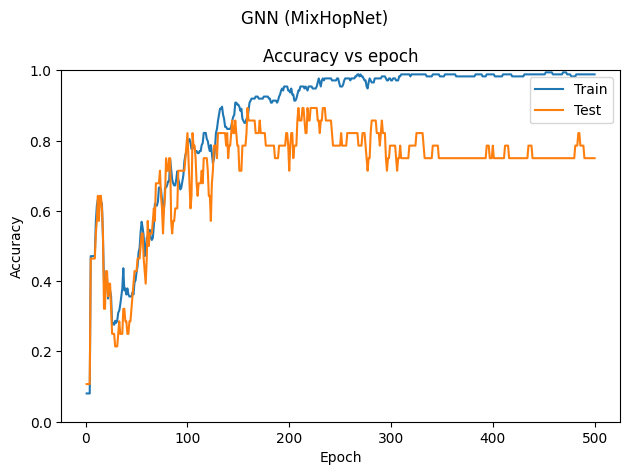

In [218]:
# Gráficas: accuracy y F1 vs epochs para train y test
epochs = range(1, max_epochs + 1)

fig, axes = plt.subplots(1, 1)
fig.suptitle("GNN (MixHopNet)")

# Accuracy
axes.plot(epochs, train_acc_hist, label="Train")
axes.plot(epochs, test_acc_hist, label="Test")
axes.set_xlabel("Epoch")
axes.set_ylabel("Accuracy")
axes.set_title("Accuracy vs epoch")
axes.set_ylim(0, 1)
axes.legend()

plt.tight_layout()
plt.show()

# Save figure
fig.savefig(f"../images/comparative_gnn_{DATASET_NAME}.png", dpi=300)